# DATA522 Final Exploration

## Library choice

* **PyArrow**: The dataset we were using was only available in the Parquet format
* **OCRMac**: We found that EasyOCR, while cross-platform, performed much worse than the built-in Apple OCR model, for which OCRMac provides a wrapper. We did use EasyOCR for our student-contributed lecture, but if we were to generate our dataset with EasyOCR, it would still be running today.
* **Transformers**: Transformers is used to download and run the `distilbert` sentiment analysis model.

## Data

Our data is available on HuggingFace at https://huggingface.co/datasets/afmck/peanuts-flan-t5-xl. Because of the size of the dataset, we elected to clone the data files without uploading them to our repository.

In [ ]:
# Install libraries for reading in Parquet and OCR
%pip install pyarrow
# If you run this on windows your computer will explode :-)
%pip install ocrmac
# %pip install pytesseract
# %pip install easyocr

# Pre-trained sentiment analysis model
%pip install transformers

# CV2 (required for image operations)
%pip install opencv-python

# NLTK (required for text analysis)
%pip install nltk

In [140]:
# Import libraries
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
# import easyocr
from ocrmac import ocrmac
import cv2
import PIL
# necessary for distilbert pipeline
from transformers import pipeline
# natural language toolkit
import nltk
# something is Not regular about these expressions
import re
# we don't know what this is
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /Users/ari/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [141]:
# Get all data Parquets
def read_dataset(dirname):
    training_filenames = sorted([
        filename 
        for filename in os.listdir(dirname) 
        if filename.endswith('.parquet') and filename.startswith('train') 
    ])
    return [
        pd.
            read_parquet(
                f'{dirname}/{filename}'
            )
            .drop(columns = ['caption']) 
        for filename in training_filenames
    ]

In [142]:
# load the easyOCR library -- removed because we decided to use OCRMac instead
# state_easyocr = {
#     "reader": easyocr.Reader(['en'])
# }

# load the distilbert pipeline
state_sentiment = {
    "pipeline": pipeline("sentiment-analysis")
}

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0


In [143]:
# stolen from https://stackoverflow.com/questions/17170752/python-opencv-load-image-from-byte-string
# (shamelessly)
def bytes2cv2(image):
    # images are stored as bytes, which we will cast into 8-bit ints
    img_bytes = image['bytes']
    return cv2.imdecode(
        np.frombuffer(
            img_bytes, 
            np.uint8
        ),
        # the glory of color
        cv2.IMREAD_COLOR_RGB
    )

# show a given image from the original dataset
def imshow(image):
    decoded_image = bytes2cv2(image)
    plt.imshow(decoded_image)
    plt.grid(False)
    plt.axis('off')
    plt.show()

# use the distilbert model to get the sentiment of an image (between -1 and 1, depending on the confidence)
def analyze_sentiment(text, state_sentiment):
    sentiment = state_sentiment["pipeline"](text)[0]
    if sentiment["label"] == "NEGATIVE":
        return -1 * sentiment["score"]
    elif sentiment["label"] == "NEUTRAL":
        return 0
    return sentiment["score"]

# def easyocr_filtertext(read_text):
#     return ' '.join(read_text).upper()
    
# def ocr_easyocr(image, state):
#     decoded_image = bytes2cv2(image)
#     return easyocr_filtertext(state['reader'].readtext(decoded_image, detail = 0))

# use OCRMac to read text from an image
def ocr_ocrmac(image):
    pil_image = PIL.Image.fromarray(
        bytes2cv2(image)
    )
    ocr_result = ocrmac.text_from_image(
        pil_image
    )
    # Get just the text from the images
    return ' '.join(
        [
            ocr_tuple[0] 
            for ocr_tuple 
            in ocr_result
        ]
    ) 


def ocr_and_text_sentiment_row(row):
    text_ocrmac = ocr_ocrmac(row.image)
    sentiment_ocrmac = analyze_sentiment(text_ocrmac, state_sentiment)
    return pd.Series(
        {
            "text_ocrmac": text_ocrmac,
            "sentiment_ocrmac": sentiment_ocrmac
        }
    )

def ocr_and_text_sentiment(df):
    df_ocr = pd.concat([df, df.apply(
        ocr_and_text_sentiment_row,
        axis = 1,
        # Expand the series into new columns
        result_type = 'expand'
    )], axis = 1)
    return df_ocr

# This function takes an extremely long time to run
# Run at your own peril

# Create pared-down dataset
def create_pared_dataset(dirname):
    training_parquets = read_dataset(dirname)
    
    for i, training_parquet in enumerate(training_parquets):
        # Do not save image data, that would be insane
        (
            ocr_and_text_sentiment(training_parquet)
            # The pared dataset will not contain the original images but will contain both
            # OCR results and sentiment analysis scores
                .drop(columns = 'image')
                .to_parquet(f'{dirname}/parquet_{i}-sentiment.parquet')
        )

# Read pared dataset so we don't have to regenerate it every time
def read_pared_dataset(dirname):
    sentiment_filenames = sorted([
        filename for filename in os.listdir(dirname) if filename.endswith('.parquet') and not filename.startswith('train')
    ])
    training_filenames = sorted([
        filename 
        for filename in os.listdir(dirname) 
        if filename.endswith('.parquet') and filename.startswith('train') 
    ])
    sentiment_parquets = [
        pd.read_parquet(f'{dirname}/{filename}').assign(filename = f'{dirname}/{training_filenames[idx]}') 
        for idx, filename in enumerate(sentiment_filenames)
    ]
    return pd.concat(sentiment_parquets).reset_index().rename(columns = {'index': 'row_within_file'})

# Get an image from the original dataset given a row from the pared-down dataset
def get_image(row):
    filename = row.filename
    row_within_file = row.row_within_file
    imshow(pd.read_parquet(filename).image.loc[row_within_file])

# Show a comic panel with the desired parameters
def show_comic_with_params(desired_positivity, desired_characters, sentiment_dataset, snoopy_absolutist):
    assert desired_positivity == 1 or desired_positivity == -1

    snoopy_aliases = [
        "Snoopy",
        "Joe Cool",
        "the World War I Flying Ace"
    ]
        
    filtered_dataset = sentiment_dataset
    
    if desired_positivity == 1:
        filtered_dataset = filtered_dataset[filtered_dataset.sentiment_ocrmac > 0]
    else:
        filtered_dataset = filtered_dataset[filtered_dataset.sentiment_ocrmac < 0]

    for character in desired_characters:
        if not snoopy_absolutist and character in snoopy_aliases:
            filtered_dataset = filtered_dataset[
                filtered_dataset.characters.map(
                    lambda characters: any([alias in characters for alias in snoopy_aliases])
                )
            ]
        else:
            filtered_dataset = filtered_dataset[
                filtered_dataset.characters.map(
                    lambda characters: character in characters
                )
            ]

    comic = filtered_dataset.sample().iloc[0]
    print(f"https://www.gocomics.com/peanuts/{comic.panel_name[:4]}/{comic.panel_name[4:6]}/{comic.panel_name[6:8]}")
    get_image(comic)
    

## graph time
##### graph time

In [144]:
sentiment_dataset = read_pared_dataset('./data')

In [145]:
sns.set_theme()

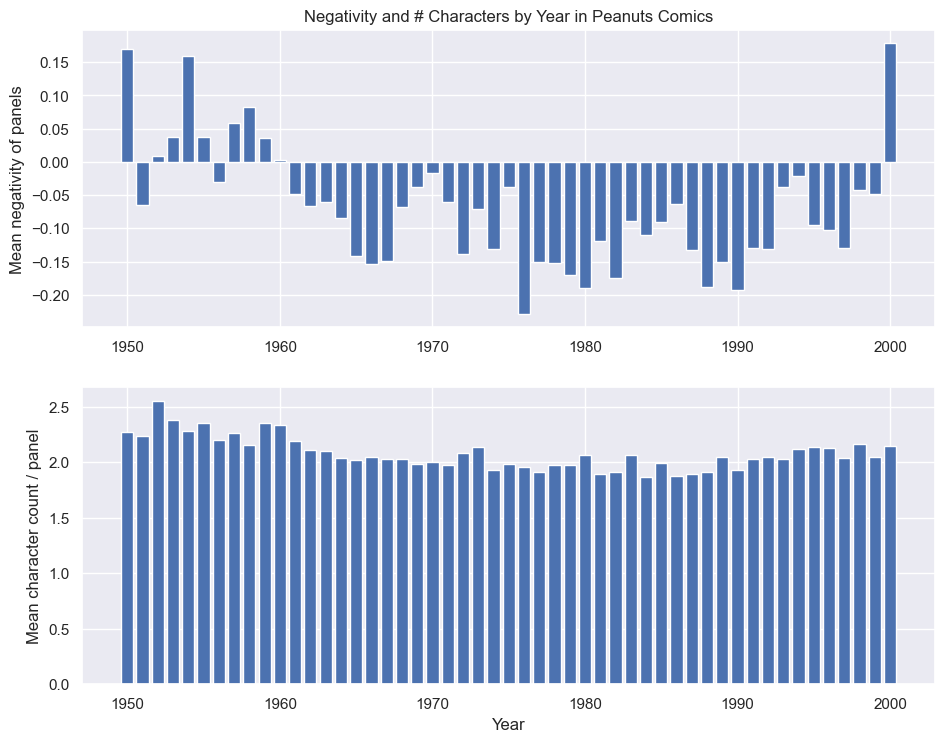

In [146]:
# Create dataset for negativity / # characters plot
sentiment_dataset_n_characters = sentiment_dataset.assign(
    n_characters = sentiment_dataset.characters.apply(lambda characters: len(characters)),
    positive_sentiment = np.int64(sentiment_dataset.sentiment_ocrmac > 0), 
    negative_sentiment = np.int64(sentiment_dataset.sentiment_ocrmac < 0)
)

plots_0_data = (
    sentiment_dataset_n_characters
        .select_dtypes(exclude = ['object'])
        .groupby('year').agg(
            {'positive_sentiment': 'sum',
            'negative_sentiment': 'sum',
            'n_characters': 'mean'}
        )
)

# Create 2-row plot
fig, ax = plt.subplots(2, 1, figsize = (11, 8.5))

ax[0].bar(plots_0_data.index, # Plot mean positivity 
          (
            plots_0_data.positive_sentiment - plots_0_data.negative_sentiment
          ) /
            (plots_0_data.positive_sentiment + plots_0_data.negative_sentiment)
         )
ax[0].set_ylabel("Mean negativity of panels")
ax[1].set_ylabel("Mean character count / panel")
ax[1].set_xlabel("Year")
ax[1].bar(plots_0_data.index, plots_0_data.n_characters)
ax[0].set_title("Negativity and # Characters by Year in Peanuts Comics")
plt.show()


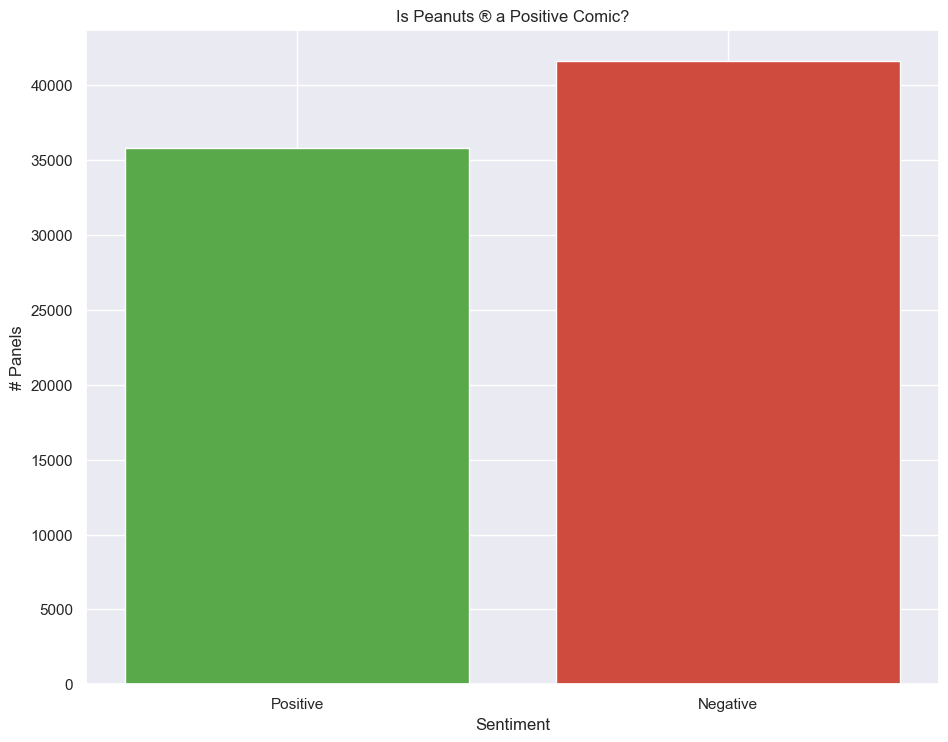

In [147]:
plots_1_data = plots_0_data[["positive_sentiment", "negative_sentiment"]].sum()
fig, ax = plt.subplots(figsize = (11, 8.5))
ax.bar(["Positive", "Negative"], [
    plots_1_data.positive_sentiment,
    plots_1_data.negative_sentiment
],
      color = ["#59A94A", "#CF4B3E"])
ax.set_ylabel("# Panels")
ax.set_xlabel("Sentiment")
ax.set_title("Is Peanuts ® a Positive Comic?")
plt.show()

In [148]:
plots_1_data

positive_sentiment    35823
negative_sentiment    41633
dtype: int64

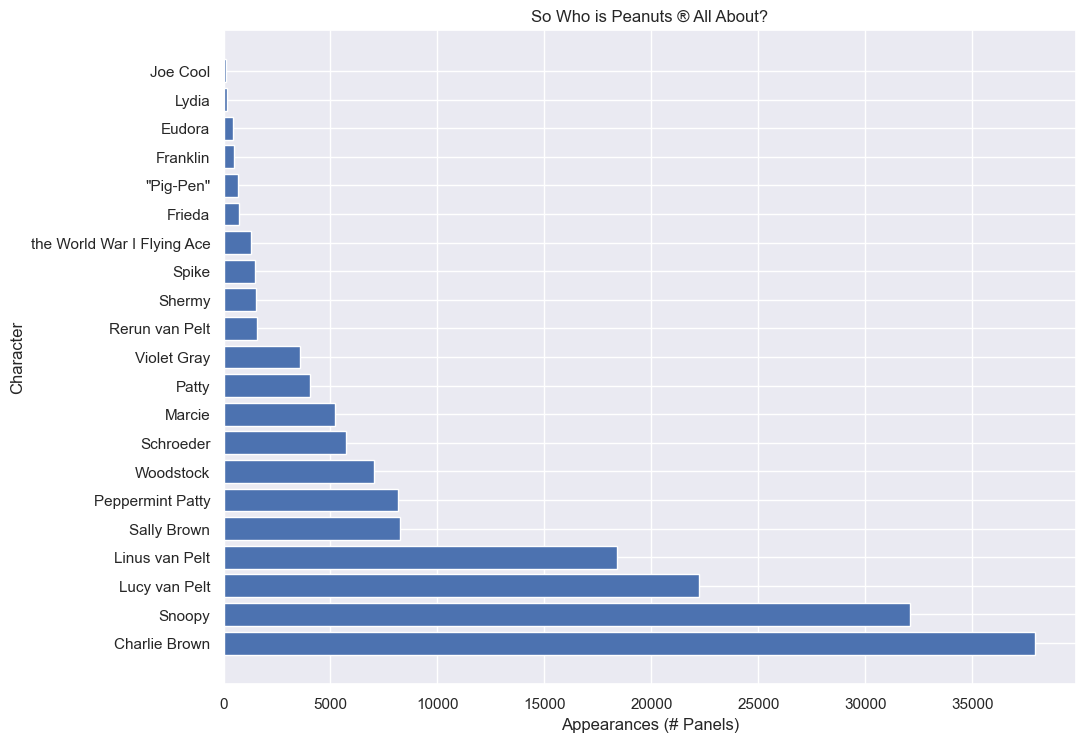

In [149]:
fig, ax = plt.subplots(figsize = (11, 8.5))
plot_2_data = sentiment_dataset.characters.explode().value_counts()
ax.barh(plot_2_data.index, plot_2_data)
ax.set_xlabel("Appearances (# Panels)")
ax.set_ylabel("Character")
ax.set_title("So Who is Peanuts ® All About?")

plt.show()

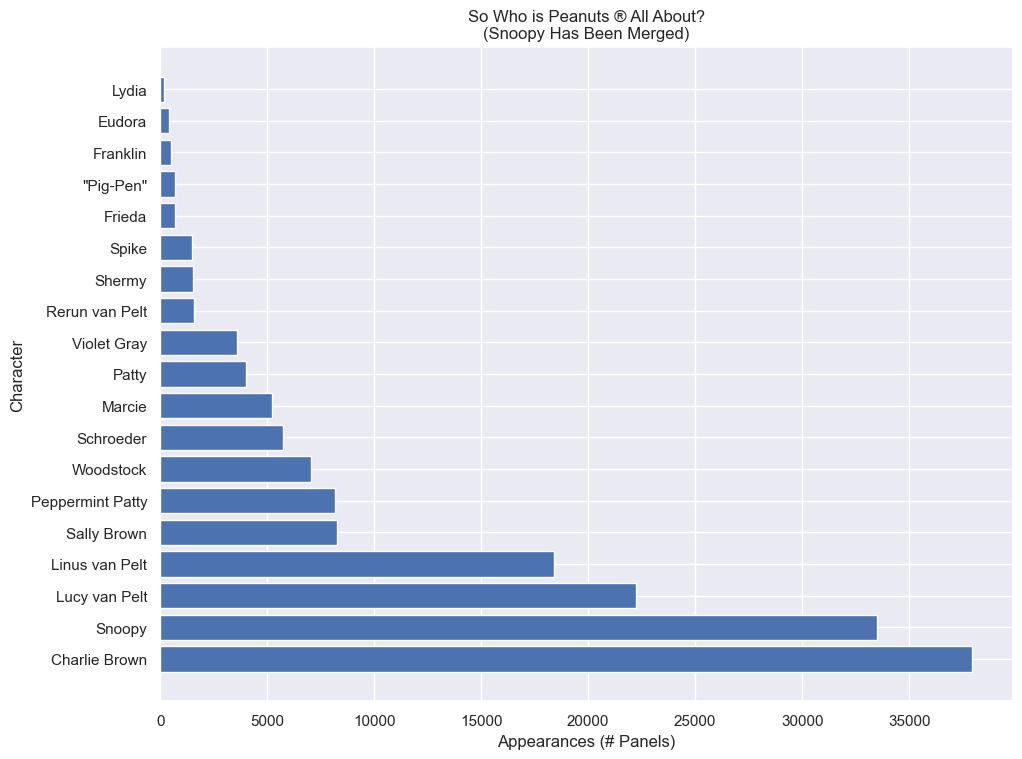

In [150]:
# Show the same graph but with Snoopy combined into one value
fig, ax = plt.subplots(figsize = (11, 8.5))
# Combine the Snoopy data
plot_3_data = sentiment_dataset.characters.explode().value_counts()
plot_3_data["Snoopy"] = plot_3_data["Snoopy"] + plot_3_data["Joe Cool"] + plot_3_data["the World War I Flying Ace"]
plot_3_data = plot_3_data.drop(
    [
        "Joe Cool",
        "the World War I Flying Ace"
    ]
)
ax.barh(plot_3_data.index, plot_3_data)
ax.set_xlabel("Appearances (# Panels)")
ax.set_ylabel("Character")
ax.set_title("So Who is Peanuts ® All About?\n(Snoopy Has Been Merged)")

plt.show()

In [160]:
plot_2_data

characters
Charlie Brown                 37950
Snoopy                        32111
Lucy van Pelt                 22213
Linus van Pelt                18401
Sally Brown                    8258
Peppermint Patty               8141
Woodstock                      7044
Schroeder                      5744
Marcie                         5225
Patty                          4024
Violet Gray                    3579
Rerun van Pelt                 1583
Shermy                         1522
Spike                          1492
the World War I Flying Ace     1266
Frieda                          702
"Pig-Pen"                       667
Franklin                        488
Eudora                          426
Lydia                           185
Joe Cool                        120
Name: count, dtype: int64

In [151]:
# Which strip has the most characters?
sentiment_dataset_n_characters.sort_values('n_characters', ascending = False).iloc[0]

row_within_file                                                     805
panel_name                                                  19731125_08
characters            [Charlie Brown, Sally Brown, Franklin, Marcie,...
themes                                                               []
color                                                         grayscale
year                                                               1973
text_ocrmac                                                            
sentiment_ocrmac                                               0.748121
filename              ./data/train-00003-of-00006-0b9796cd01490340.p...
n_characters                                                         10
positive_sentiment                                                    1
negative_sentiment                                                    0
Name: 39534, dtype: object

# Which Phrases are the most notable?

In [152]:
# generate The String
all_peanut_text = re.sub(
        # Remove common non-text words
        r'([^\w\s]|United|Feature|Syndicate|19[0-9][0-9]|2000)',
        "",
        "\n"
        .join(sentiment_dataset.text_ocrmac.to_list())
        # Replace common OCR errors
        .replace("15", "IS")
        .replace("WARI", "WAR I")
        .replace("WARII", "WAR II")
        .replace("OL", "OLD")
        .replace("OLE", "OLD")
        .replace("OLDD", "OLD")
).upper()

# tokens from The String
peanut_tokens = nltk.word_tokenize(all_peanut_text)

# find 2-, 3-, and 4-word phrases
collocation_finders = [
    collocation_finder.from_words(peanut_tokens) for collocation_finder in
    (
        nltk.collocations.BigramCollocationFinder,
        nltk.collocations.TrigramCollocationFinder,
        nltk.collocations.QuadgramCollocationFinder
    )
]
association_measures = (
    nltk.collocations.BigramAssocMeasures,
    nltk.collocations.TrigramAssocMeasures,
    nltk.collocations.QuadgramAssocMeasures
)

In [153]:
# get our 100 best??? ngrams
n = 100
best_ngrams = [
    # we are students so we will use student T test 🤓☝️
    collocation_finder.nbest(association_measure.student_t, n)
    for collocation_finder, association_measure in
    zip(
        collocation_finders,
        association_measures
    )
]

In [154]:
# Get the top 100 n-grams as a list
top_ngrams = [[" ".join(phrase) for phrase in ngram] for ngram in best_ngrams]

In [155]:
sentiment_text = sentiment_dataset.text_ocrmac.apply(lambda text:
    re.sub(r'\s+', ' ', 
           re.sub(r'([^\w\s]|United|Feature|Syndicate|19[0-9][0-9]|2000)',
            "",
            # Replace common mistakes
            text.replace("15", "IS")
            .replace("WARI", "WAR I")
            .replace("WARII", "WAR II")
            .replace("OL", "OLD")
            .replace("OLE", "OLD")
            .replace("OLDD", "OLD")).upper()
))

In [156]:
def find_token_matches(token, sentiment_text):
    return int(sentiment_text.str.contains(token).sum())

In [157]:
top_ngrams_match_counts = [[(phrase, find_token_matches(phrase, sentiment_text)) for phrase in phrase_list] for phrase_list in top_ngrams]
# find_token_matches("CHARLIE BROWN", sentiment_text)

In [158]:
top_ngrams_sorted = pd.DataFrame([
    (idx + 2, match_count[0], match_count[1]) for idx, ngram in enumerate(top_ngrams_match_counts) for match_count in ngram
], columns = ['n', 'n-gram', 'count']).sort_values(by = ['n', 'count'], ascending = [True, False])

top_ngrams_sorted.to_csv('./data/top_ngrams_sorted.csv')

# Generate a Comic

Change the below configuration variables to generate a comic with the desired positivity/negativity and with the desired character(s) (optional):

https://www.gocomics.com/peanuts/1968/04/26


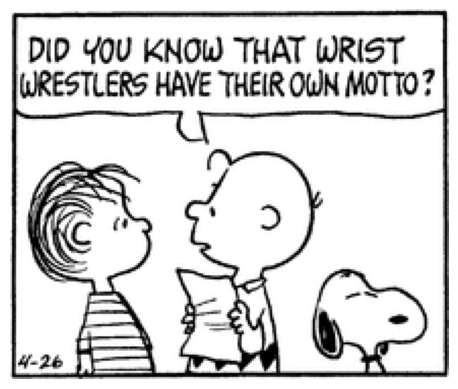

In [159]:
# Use 1 for positive comics, -1 for negative comics
desired_positivity = -1
desired_characters = ["Snoopy"]
# If this is False, Snoopy will match all of his aliases
snoopy_absolutist = False

# Show the actual comic
show_comic_with_params(desired_positivity, desired_characters, read_pared_dataset("./data"), snoopy_absolutist)